In [1]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
# plt.style.use("/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/paper.mplstyle")

In [2]:
def select_percent(failure_type: str, resilience: int, node: int) -> pd.DataFrame:
    # Connect to the SQLite database
    conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/mapreduce_correct.db')

    # 统计resilience=1中且workflow_finish=1的作业占比
    query = f"""
    SELECT COUNT(*)
    FROM workflow
    WHERE resilience={resilience}
    AND failure_type = '{failure_type}'
    AND makespan IS NOT NULL
    AND failure_rate_set=1
    AND workflow_finish=1
    AND node_cnt={node}
    """
    
    # Load data into a DataFrame
    df = pd.read_sql_query(query, conn)
    s = df.iloc[0, 0]

    query = f"""
    SELECT COUNT(*)
    FROM workflow
    WHERE resilience={resilience}
    AND failure_type = '{failure_type}'
    AND makespan IS NOT NULL
    AND failure_rate_set=1
    AND node_cnt={node}
    """
    df = pd.read_sql_query(query, conn)
    t = df.iloc[0, 0]

    # Close the database connection
    conn.close()

    print(f"resilience={resilience}, node={node}, success={s}, total={t}")

    return s / t


In [3]:
def get_failure_data(failure_type: str):
    wz_r = {}
    wz_nr = {}
    for node in [2, 5, 9, 17, 33]:
        for resilience in [0, 1]:
            if resilience == 0:
                wz_nr[node-1] = select_percent(failure_type, resilience, node)
            else:
                wz_r[node-1] = select_percent(failure_type, resilience, node)
    print(wz_r)
    print(wz_nr)
    return wz_r, wz_nr

In [7]:
def plot_failure(failure_type: str):
    wz_r, wz_nr = get_failure_data(failure_type)
    plt.figure(figsize=(4, 2.4))

    # sns.set_palette("pastel")
    pastel_palette = sns.color_palette("pastel")
    blue_color = pastel_palette[0]  # 蓝色
    orange_color = pastel_palette[1]  # 橙色
    custom_palette = {
        'Parsl with WRATH': orange_color,
        'Parsl without WRATH': blue_color
    }
    sns.set_style("whitegrid")

    plt.rc('font', size=10)  # 控制默认文本的大小
    plt.rc('axes', titlesize=10)  # 控制标题的大小
    plt.rc('axes', labelsize=10)  # 控制x轴和y轴标签的大小
    plt.rc('xtick', labelsize=10)  # 控制x轴刻度的大小
    plt.rc('ytick', labelsize=10)  # 控制y轴刻度的大小
    plt.rc('legend', fontsize=10)  # 控制图例的字体大小

    ax = sns.lineplot(x=wz_r.keys(), y=wz_r.values(), label='Parsl with WRATH', marker='o', color=orange_color)
    sns.lineplot(x=wz_nr.keys(), y=wz_nr.values(), label='Parsl without WRATH', marker='o', color=blue_color)

    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of nodes')
    ax.set_ylabel('Success rate')
    # ax.set_title('Workflow Finish Rate vs. Number of Nodes')
    plt.tight_layout()
    plt.savefig(f'/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/scale_{failure_type}.pdf')

    plt.show()


resilience=0, node=2, success=1, total=38
resilience=1, node=2, success=45, total=47
resilience=0, node=5, success=2, total=19
resilience=1, node=5, success=49, total=49
resilience=0, node=9, success=3, total=40
resilience=1, node=9, success=49, total=49
resilience=0, node=17, success=6, total=40
resilience=1, node=17, success=48, total=48
resilience=0, node=33, success=1, total=39
resilience=1, node=33, success=46, total=47
{1: np.float64(0.9574468085106383), 4: np.float64(1.0), 8: np.float64(1.0), 16: np.float64(1.0), 32: np.float64(0.9787234042553191)}
{1: np.float64(0.02631578947368421), 4: np.float64(0.10526315789473684), 8: np.float64(0.075), 16: np.float64(0.15), 32: np.float64(0.02564102564102564)}


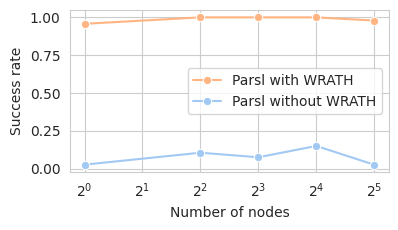

In [8]:
plot_failure('memory')

resilience=0, node=2, success=3, total=50
resilience=1, node=2, success=49, total=50
resilience=0, node=5, success=1, total=50
resilience=1, node=5, success=45, total=50
resilience=0, node=9, success=2, total=50
resilience=1, node=9, success=50, total=50
resilience=0, node=17, success=3, total=50
resilience=1, node=17, success=48, total=50
resilience=0, node=33, success=1, total=50
resilience=1, node=33, success=50, total=50
{1: np.float64(0.98), 4: np.float64(0.9), 8: np.float64(1.0), 16: np.float64(0.96), 32: np.float64(1.0)}
{1: np.float64(0.06), 4: np.float64(0.02), 8: np.float64(0.04), 16: np.float64(0.06), 32: np.float64(0.02)}


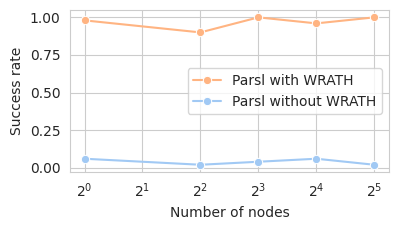

In [9]:
plot_failure('import')

In [10]:
def select_data():
    # Connect to the SQLite database
    conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/mapreduce_correct.db')
    query = f"""
    SELECT failure_type, node_cnt, overhead/task_count AS overhead_per_task
    FROM workflow
    WHERE resilience=1
    AND makespan IS NOT NULL
    ORDER BY node_cnt AND failure_type
    """
    df = pd.read_sql_query(query, conn)
    return df

In [13]:
df = select_data()
# df中node_cnt每个-1
df['node_cnt'] = df['node_cnt'] - 1
# calculate average and standard deviation
df = df.groupby(['failure_type', 'node_cnt']).agg({'overhead_per_task': ['mean', 'std']}).reset_index()
df.columns = ['failure_type', 'node_cnt', 'mean', 'std']
df

,failure_type,node_cnt,mean,std
0,import,1,0.674350,0.335511
1,import,2,0.710170,0.387364
2,import,4,0.752555,0.321830
3,import,8,0.785480,0.449079
4,import,16,0.873610,0.417977
5,import,32,1.063820,0.562741
6,memory,1,0.191447,0.323860
7,memory,2,0.107255,0.203132
8,memory,4,0.112577,0.303354
9,memory,8,0.104729,0.289089


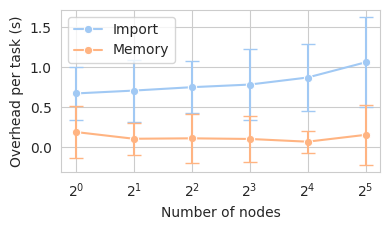

In [14]:
plt.figure(figsize=(4, 2.4))

sns.set_palette("pastel")
sns.set_style("whitegrid")

plt.rc('font', size=10)  # 控制默认文本的大小
plt.rc('axes', titlesize=10)  # 控制标题的大小
plt.rc('axes', labelsize=10)  # 控制x轴和y轴标签的大小
plt.rc('xtick', labelsize=10)  # 控制x轴刻度的大小
plt.rc('ytick', labelsize=10)  # 控制y轴刻度的大小
plt.rc('legend', fontsize=10)  # 控制图例的字体大小


ax = sns.lineplot(x='node_cnt', y='mean', hue='failure_type', data=df, marker='o')

# Get the colors used by seaborn
palette = sns.color_palette("pastel", len(df['failure_type'].unique()))
color_dict = {ftype: palette[i] for i, ftype in enumerate(df['failure_type'].unique())}

# Add error bars manually with the same color as the lines
for i, row in df.iterrows():
    plt.errorbar(x=row['node_cnt'], y=row['mean'], yerr=row['std'], 
                fmt='none', c=color_dict[row['failure_type']], capsize=5)
    
# 获取当前图例
handles, labels = plt.gca().get_legend_handles_labels()

# 将每个图例项的标签首字母大写
new_labels = []
for label in labels:
    new_labels.append(label.capitalize())

# 绘制图例并设置新的标签
plt.legend(handles, new_labels)

ax.set_xscale('log', base=2)
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Overhead per task (s)')
plt.tight_layout()
plt.savefig(f'/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/mapreduce_overhead.pdf')

plt.show()